In [47]:

import networkx as nx
import numpy as np
import random, math

import time


import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm



Jackson model
* Start with m nodes
* New nodes are introduced to m nodes
* Befriend with probability pm
* New nodes are then introduced to n of those pm nodes' connections
* Befriend with probability pn
* Continue for as many iterations as would like

Nicer version

In [135]:

# parameter selection

# initial nodes and time
initial_n = 100
T = 10

# parent nodes and prob
m = 1
pm = 0.2

# parent neighbours and prob
n = 1
pn = 0.1


new_sim = JacksonSimulation(initial_n, T, m, pm, n, pn)


initial_nodes = [i+1 for i in range(initial_n)]

graph_0 = new_sim.graph_history[0]
graph_T = new_sim.graph_history[-1]


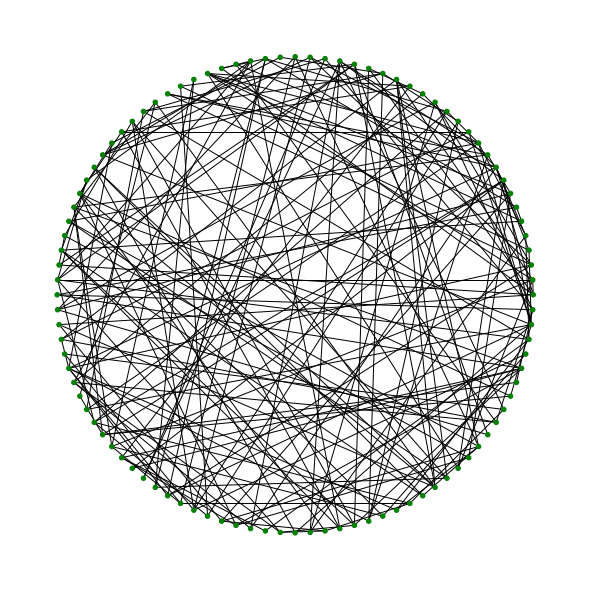

In [136]:

plt.figure(figsize=(8,8))

colormap_0 = ['green' if node in initial_nodes else 'red' for node in graph_0]
nx.draw_circular(new_sim.graph_history[0], node_color = colormap_0, node_size = 20, with_labels=False)

plt.show()


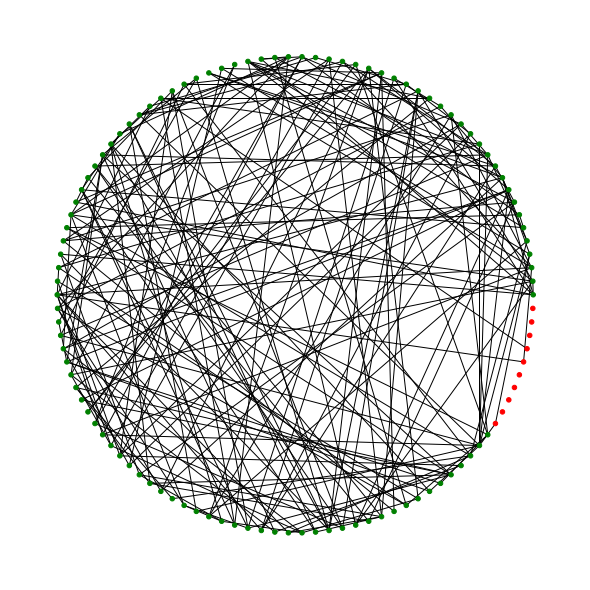

In [138]:

plt.figure(figsize=(8,8))

colormap_T = ['green' if node in initial_nodes else 'red' for node in graph_T]
nx.draw_circular(new_sim.graph_history[-1], node_color = colormap_T, node_size = 20, with_labels=False)

plt.show()


In [87]:

class JacksonSimulation():

    def __init__(self, initial_n, T, m, pm, n, pn):

        # parameters
        self.initial_n = initial_n
        self.T = T
        self.m = m
        self.pm = pm
        self.n = n
        self.pn = pn

        # also maybe add options for the functions used
        # self.initialiser_function = 



        # simulation memory
        self.period = 0
        self.graph_history = []
        # will also need a matrix history to make it easier to save simulations to a csv or the like


        # starting stuff
        self.initial_nodes = [i+1 for i in range(initial_n)] # create n initial nodes, +1 for name to start at 1

        self.main()


    '''MAIN'''
    def main(self):
        # make the initial graph
        self.save_update_to_memory(self.initial_node_connector_basic())


        for t in range(self.T):
            self.update_simulation(self.graph_history[-1])




    '''INITIALISATION'''
    # basic version: all nodes get a certain number of connections
    def initial_node_connector_basic(self):
        initial_graph = nx.Graph()
        initial_graph.add_nodes_from(self.initial_nodes)

        for node in self.initial_nodes:
            possible_links = self.initial_nodes.copy()
            possible_links.remove(node) # remove own node
            
            # randomly chooses m+n nodes without replacement from the initial nodes to connect (correction for taking the number of nodes instead if m+n>initial_n)
            initial_neighbours = list(np.random.choice(possible_links, min(self.m + self.n, self.initial_n-1), replace=False))
            
            # creates the edges
            '''for some reason it's treating this as 3 arguments?'''
            initial_edges = self.edge_creator_helper(node, initial_neighbours)
            initial_graph.add_edges_from(initial_edges)

        return initial_graph


    



    '''UPDATING'''
    # big simulation update
    def update_simulation(self, current_graph):
        # get the connections for the new node
        parent_connections = self.find_parent_nodes_connections(current_graph) # DONE
        parent_neighbour_connections = self.find_parent_neighbour_connections(current_graph, parent_connections) # DONE

        # add the new node
        new_node = self.new_node_birth(current_graph) # DONE
        
        
        # combine the two
        new_node_connections = np.concatenate((parent_connections, parent_neighbour_connections))
        new_node_edges = self.edge_creator_helper(new_node, new_node_connections)

        # copy graph with the added connections
        new_graph = current_graph.copy()
        new_graph.add_node(new_node)
        new_graph.add_edges_from(new_node_edges)

        self.save_update_to_memory(new_graph)
    
    
    # create new node, indexed as the next number in the list
    def new_node_birth(self, graph):
        current_nodes = graph.nodes()
        new_node = max(current_nodes) + 1

        return new_node

    # find parent nodes connections
    def find_parent_nodes_connections(self, graph):
        # get the current existing nodes
        current_nodes = graph.nodes()

        # get m parent nodes
        parent_targets = np.random.choice(current_nodes, m, replace=False)

        # probability pm to connect to each m of them
        parents_edge_chance = np.random.choice([0,1], size=self.m, p=[1-self.pm, self.pm])

        # realised connections: cross product of the two vectors
        parent_connections = parent_targets * parents_edge_chance
        parent_connections = parent_connections[parent_connections > 0] # filter out the ones with no connection


        return parent_connections

    # find parent neighbour connections
    def find_parent_neighbour_connections(self, graph, parent_connections_list):
        # take the list of parents and find their (unique) neighbours
        parent_neighbours = np.unique(self.find_neighbours(graph, parent_connections_list))

        # to avoid issues: if the parents have in total less than n neighbours, take their number of neighbours instead
        n_possible_encounters = min(len(parent_neighbours), self.n)

        # get n parent neighbour nodes
        parent_neighbour_targets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False)

        # probability pn to connect to each n of them
        parent_neighbours_edge_chance = np.random.choice([0,1], size = n_possible_encounters, p = (1-self.pn, self.pn))

        # realised connections: cross product of the two vectors
        parent_neighbours_connections = parent_neighbour_targets * parent_neighbours_edge_chance
        parent_neighbours_connections = parent_neighbours_connections[parent_neighbours_connections > 0] # filter out the ones with no connection


        return parent_neighbours_connections

    # save to history
    def save_update_to_memory(self, updated_graph):
        # save new graph to history
        '''may need to make a history for t as well, if I end up not creating new nodes every iteration'''
        self.graph_history.append(updated_graph)




    '''useful functions'''
    # creates a list of edges based on targets 
    def edge_creator_helper(self, node, connection_targets):
        edges = [(node, connection_target) for connection_target in connection_targets]

        return edges

    # returns list of neighbours for all the nodes in the given list
    def find_neighbours(self, graph, node_list):
        if len(node_list) != 0:
            all_neighbours_list = np.concatenate(([list(graph[node]) for node in node_list]))
        else:
            all_neighbours_list = []

        return all_neighbours_list




Looped version

In [455]:

m = 5
n = 5
initial_n = 20
T = 100

pm = 0.25
pn = 0.1

# initialise with m nodes
#G.clear()
G = nx.Graph()
G.add_nodes_from([i+1 for i in range(initial_n)])

'''each node needs at least m+n connections'''
initial_nodes = list(G.nodes())

if True:
    for node in initial_nodes:
        possible_links = initial_nodes.copy()
        possible_links.remove(node) # remove own node
        
        initial_neighbours = np.random.choice(possible_links, m+n, replace=False)
        initial_edges = [(initial_neighbour, node) for initial_neighbour in initial_neighbours]
        G.add_edges_from(initial_edges)

#colormap = ['green' if node in initial_nodes else 'red' for node in G]
#nx.draw_circular(G, node_color = colormap, with_labels = True)



for t in range(T):
    # Begin
    current_nodes = list(G.nodes())
    new_node = max(current_nodes) + 1


    # Find parent nodes
    parent_nodes = np.random.choice(current_nodes, m, replace=False) * np.random.choice([0,1], size=m, p=[1-pm,pm])
    parent_nodes = parent_nodes[parent_nodes > 0]
    parent_edges = [(new_node, parent_node) for parent_node in parent_nodes]

    G.add_node(new_node)

    #colormap = ['green' if node in initial_nodes else 'red' for node in G]
    #nx.draw_networkx(G, node_color = colormap, with_labels = True)


    # Parent neighbour nodes
    if np.array(parent_nodes).size == 0:
        parent_neighbours = []
    else:
        parent_neighbours = np.concatenate(([list(G[parent]) for parent in parent_nodes]))


    parent_neighbours_meets = np.zeros(1) # initialise

    if np.array(parent_neighbours).size != 0: # check if empty
        
        # define the number of encounters: if the parent has fewer neighborus
        n_possible_encounters = min(parent_neighbours.size, n)
        #print(n_possible_encounters)

        parent_neighbours_meets = np.random.choice(parent_neighbours, n_possible_encounters, replace=False) * np.random.choice([0,1], size = n_possible_encounters, p = [1-pn, pn])
        #print(np.random.choice(parent_neighbours, n_possible_encounters, replace=False))
        #print(parent_neighbours)
        parent_neighbours_meets = parent_neighbours_meets[parent_neighbours_meets > 0]
    else:
        pass

    # combine the two connection lists
    connection_targets = np.concatenate((parent_nodes, parent_neighbours_meets))

    # remove own links
    if new_node in connection_targets: connection_targets.remove(new_node)

    connections = [(new_node, node) for node in connection_targets]


    G.add_edges_from(connections)


    #colormap = ['green' if node in initial_nodes else 'red' for node in G]
    #nx.draw_circular(G, node_color = colormap, with_labels=True)






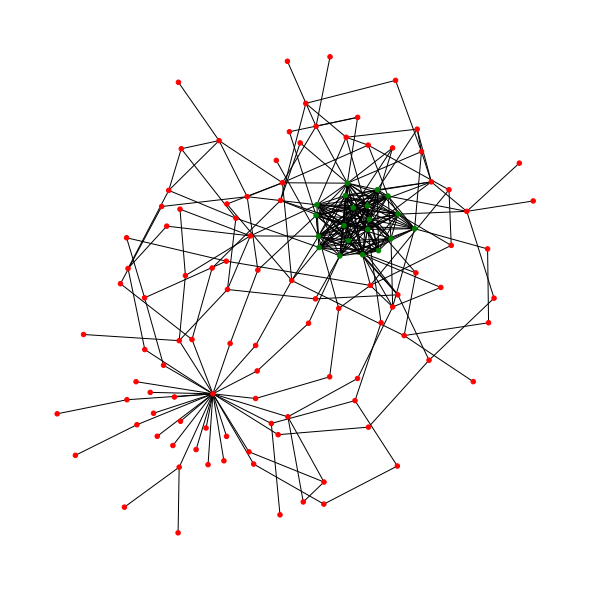

In [473]:
plt.figure(figsize=(8,8))

colormap = ['green' if node in initial_nodes else 'red' for node in G]
nx.draw_kamada_kawai(G, node_color = colormap, node_size = 20, with_labels=False)

plt.show()

### Stepped version

Initialisation

In [359]:

np.concatenate([np.array(G[i]) for i in [1,2,3]])


array([16,  8, 14,  7, 15,  9, 18, 10, 17, 11,  2,  4, 13, 14, 16,  1, 11,
       17,  5,  9,  4, 12,  7,  3,  6,  8, 10, 13, 19, 17,  7,  5, 15,  2,
       11, 10,  9, 14, 18,  6, 12, 13, 16])

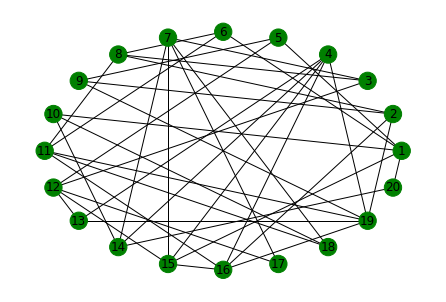

In [195]:

m = 1
n = 1
initial_n = 20

pm = 0.5
pn = 0.5

# initialise with m nodes
#G.clear()
G = nx.Graph()
G.add_nodes_from([i+1 for i in range(initial_n)])

'''each node needs at least m+n connections'''
initial_nodes = list(G.nodes())

if True:
    for node in initial_nodes:
        possible_links = initial_nodes.copy()
        possible_links.remove(node) # remove own node
        
        initial_neighbours = np.random.choice(possible_links, m+n, replace=False)
        initial_edges = [(initial_neighbour, node) for initial_neighbour in initial_neighbours]
        G.add_edges_from(initial_edges)

colormap = ['green' if node in initial_nodes else 'red' for node in G]
nx.draw_circular(G, node_color = colormap, with_labels = True)


Meeting parents

[22]


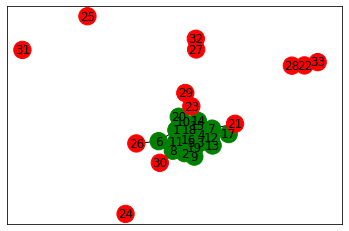

In [209]:

current_nodes = list(G.nodes())
new_node = max(current_nodes)

# dot product to only keep the ones with 1
parent_nodes = np.random.choice(current_nodes, m, replace=False) * np.random.choice([0,1], size=m, p=[1-pm,pm])
parent_nodes = parent_nodes[parent_nodes > 0]
parent_edges = [(new_node, parent_node) for parent_node in parent_nodes]

print(parent_nodes)

G.add_node(new_node)
G.add_edges_from(parent_edges)

colormap = ['green' if node in initial_nodes else 'red' for node in G]
nx.draw_networkx(G, node_color = colormap, with_labels = True)



Meeting parents' neighbours

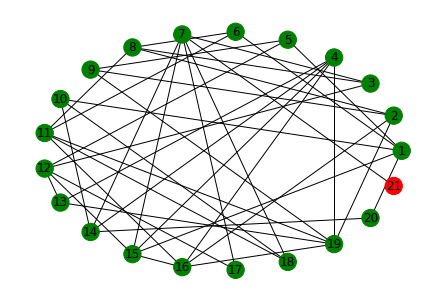

In [197]:

parent_neighbours = np.unique(np.array([list(G[parent]) for parent in parent_nodes]))
parent_neighbours_meets = np.random.choice(parent_neighbours, n, replace=False) * np.random.choice([0,1], size = n, p = [1-pn, pn])
parent_neighbours_meets = parent_neighbours_meets[parent_neighbours_meets > 0]
parent_neighbour_edges = [(new_node, parent_neighbour) for parent_neighbour in parent_neighbours_meets]

G.add_edges_from(parent_neighbour_edges)

colormap = ['green' if node in initial_nodes else 'red' for node in G]
nx.draw_circular(G, node_color = colormap, with_labels=True)
